# The Winton Stock Market Challenge

## Loading the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from zipfile import ZipFile
from mlxtend.plotting import heatmap

# Upgrade sklearn. It needs to be at least version 0.24.
# ! pip install sklearn --upgrade

import sklearn
from sklearn.metrics import mean_absolute_error, r2_score
# from sklearn.metrics import mean_absolute_percentage_error # Version not recent enough

# Read the training data.
zip_file = ZipFile('../input/the-winton-stock-market-challenge/train.csv.zip')
df = pd.read_csv(zip_file.open('train.csv'))
df.head()

,Id,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Ret_175,Ret_176,Ret_177,Ret_178,Ret_179,Ret_180,Ret_PlusOne,Ret_PlusTwo,Weight_Intraday,Weight_Daily
0,1,NaN,NaN,NaN,NaN,8.0,NaN,75751,0.2254,11.0,...,-0.002688,0.002246,-0.000838,-6.953224e-04,0.000003,-0.001974,-0.019512,0.028846,1.251508e+06,1.564385e+06
1,2,NaN,NaN,NaN,NaN,3.0,0.388896,17369,0.0166,13.0,...,-0.000129,0.000123,0.000248,3.315418e-07,0.000003,0.000027,-0.002939,-0.010253,1.733950e+06,2.167438e+06
2,3,NaN,-0.696727,0.739591,-0.167928,9.0,0.471947,8277,0.3650,9.0,...,-0.000524,-0.000394,0.000116,5.322557e-04,0.000274,0.000784,-0.024791,0.015711,1.529197e+06,1.911497e+06
3,4,NaN,-0.694350,1.568248,0.479073,5.0,0.120653,22508,0.2654,13.0,...,0.000346,-0.000090,0.000288,-1.281102e-04,0.000074,0.000341,-0.005680,-0.002190,1.711569e+06,2.139462e+06
4,5,6.0,-1.736489,2.765531,1.245280,7.0,4.866985,22423,0.2138,13.0,...,-0.001235,0.000027,0.002449,8.619882e-06,0.001209,-0.000004,0.036104,-0.026552,1.267270e+06,1.584088e+06


In [2]:
# This is not the testing data. It will help us make predictions and a submission.
zip_file = ZipFile('../input/the-winton-stock-market-challenge/test_2.csv.zip')
submission_df = pd.read_csv(zip_file.open('test_2.csv'))
submission_df.head()

# Note that throughout the notebook "submission_" is appended to a variable name to show that it refers to data that will be submitted to Kaggle.

,Id,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Ret_111,Ret_112,Ret_113,Ret_114,Ret_115,Ret_116,Ret_117,Ret_118,Ret_119,Ret_120
0,1,1.0,1.412783,-0.056284,NaN,10.0,0.413226,18871,0.2138,11.0,...,0.000370,-0.000762,NaN,0.000366,-0.002444,-0.001301,-0.000917,0.000762,-0.000556,0.000759
1,2,NaN,NaN,0.907973,1.002425,7.0,-0.257825,5852,0.2138,13.0,...,0.000457,0.000003,-0.000007,-0.000003,-0.000012,-0.000463,-0.000003,-0.000002,0.000468,-0.000012
2,3,NaN,-0.607583,1.076668,0.517865,5.0,0.947340,76935,0.0105,10.0,...,0.000003,0.000157,-0.000181,0.000003,NaN,0.000164,0.000353,0.000704,-0.000168,-0.000006
3,4,NaN,2.230240,0.223222,NaN,1.0,NaN,84573,0.3318,13.0,...,0.000010,-0.000792,-0.000479,0.000017,0.000170,-0.001079,0.000320,0.000006,0.001392,-0.001850
4,5,NaN,0.360399,0.597896,-0.145497,10.0,0.275744,89615,0.0099,8.0,...,0.000447,0.000489,-0.000233,-0.000495,0.000057,-0.000050,-0.000011,-0.000377,0.000227,-0.000114


## Dealing with missing values

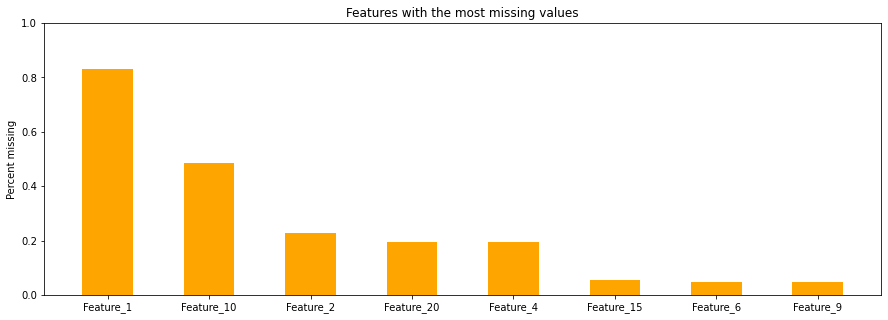

In [3]:
fig, ax = plt.subplots(figsize = (15, 5))
df_missing = (df.isnull().sum() / len(df))
df_missing = df_missing.drop(df_missing[df_missing == 0].index).sort_values(ascending = False)[: 8]
ax.bar(range(df_missing.size), df_missing, width = 0.5, color='orange')
plt.xticks(range(df_missing.size), df_missing.index, rotation=0)
plt.ylim([0, 1])
plt.title('Features with the most missing values')
plt.ylabel('Percent missing')
plt.show()

## Intraday return prediction

In [4]:
# This adds up the 120 minutes of intraday data.
ret = df.loc[:, 'Ret_2':'Ret_120'].sum(1)
new_ret = submission_df.loc[:, 'Ret_2':'Ret_120'].sum(1)
ret

0       -0.025248
1       -0.008142
2       -0.000633
3        0.001276
4       -0.002293
           ...   
39995    0.002783
39996    0.011472
39997    0.014457
39998    0.009821
39999   -0.013476
Length: 40000, dtype: float64

In [5]:
# The hstack function combines the selected features with the calculated return feature.
X = np.hstack((df.loc[:, 'Feature_1':'Ret_MinusOne'].values, ret.values[:, np.newaxis]))
ts = df.loc[:, 'Ret_2':'Ret_120'].values  # Historical minute data
y = df.loc[:, 'Ret_PlusOne':'Ret_PlusTwo'].values  # Daily data we are predicting
y_ts = df.loc[:, 'Ret_121':'Ret_180'].values  # Intraday data we are predicting.

# Combining the data for the submission dataset.
submission_X = np.hstack((submission_df.loc[:, 'Feature_1':'Ret_MinusOne'].values, new_ret.values[:, np.newaxis]))
submission_ts = submission_df.loc[:, 'Ret_2':'Ret_120'].values  # Intraday data we are predicting.

In [6]:
# Imputation with the mean value.
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'mean')
X = imputer.fit_transform(X)
submission_X = imputer.transform(submission_X)

ts = imputer.fit_transform(ts)
submission_ts = imputer.transform(submission_ts)

## Show plots of current and future intraday returns

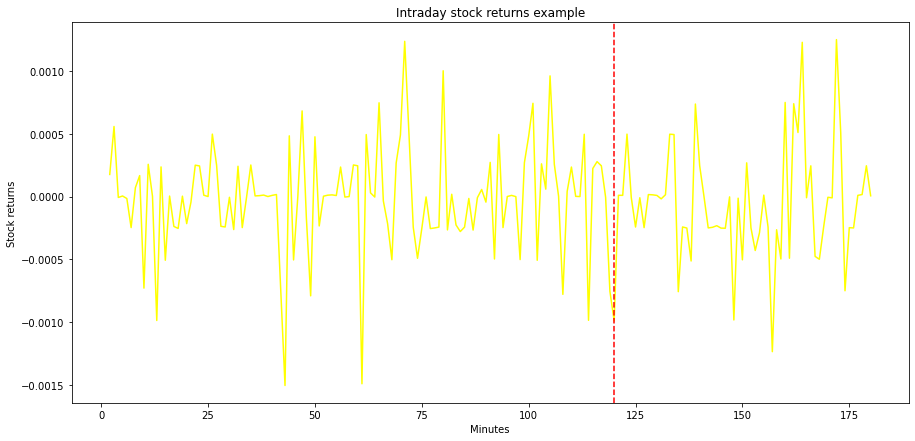

In [7]:
def saveIntradayReturnsImage(yValues, color, fileName):
    xValues = range(2, 181)
    plt.figure(figsize=(15,7))
    plt.plot(xValues, yValues, color=color)
    plt.axvline(x=120, color='red', linestyle='--')
    plt.xlabel('Minutes')
    plt.ylabel('Stock returns')
    plt.title('Intraday stock returns example')
    plt.savefig(fileName, dpi=300)

yValues = df.loc[7, 'Ret_2':'Ret_180'].values
saveIntradayReturnsImage(yValues, 'yellow', 'Intraday location 7')

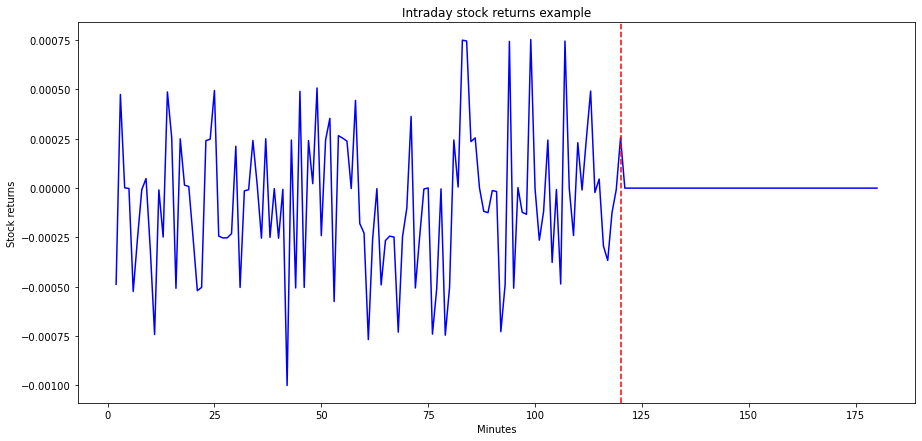

In [58]:
yValues = list(df.loc[1, 'Ret_2':'Ret_120'].values) + list(np.zeros((60)))
saveIntradayReturnsImage(yValues, 'blue', 'Intraday location 1 with 0 predicted')

## Correlation Analysis

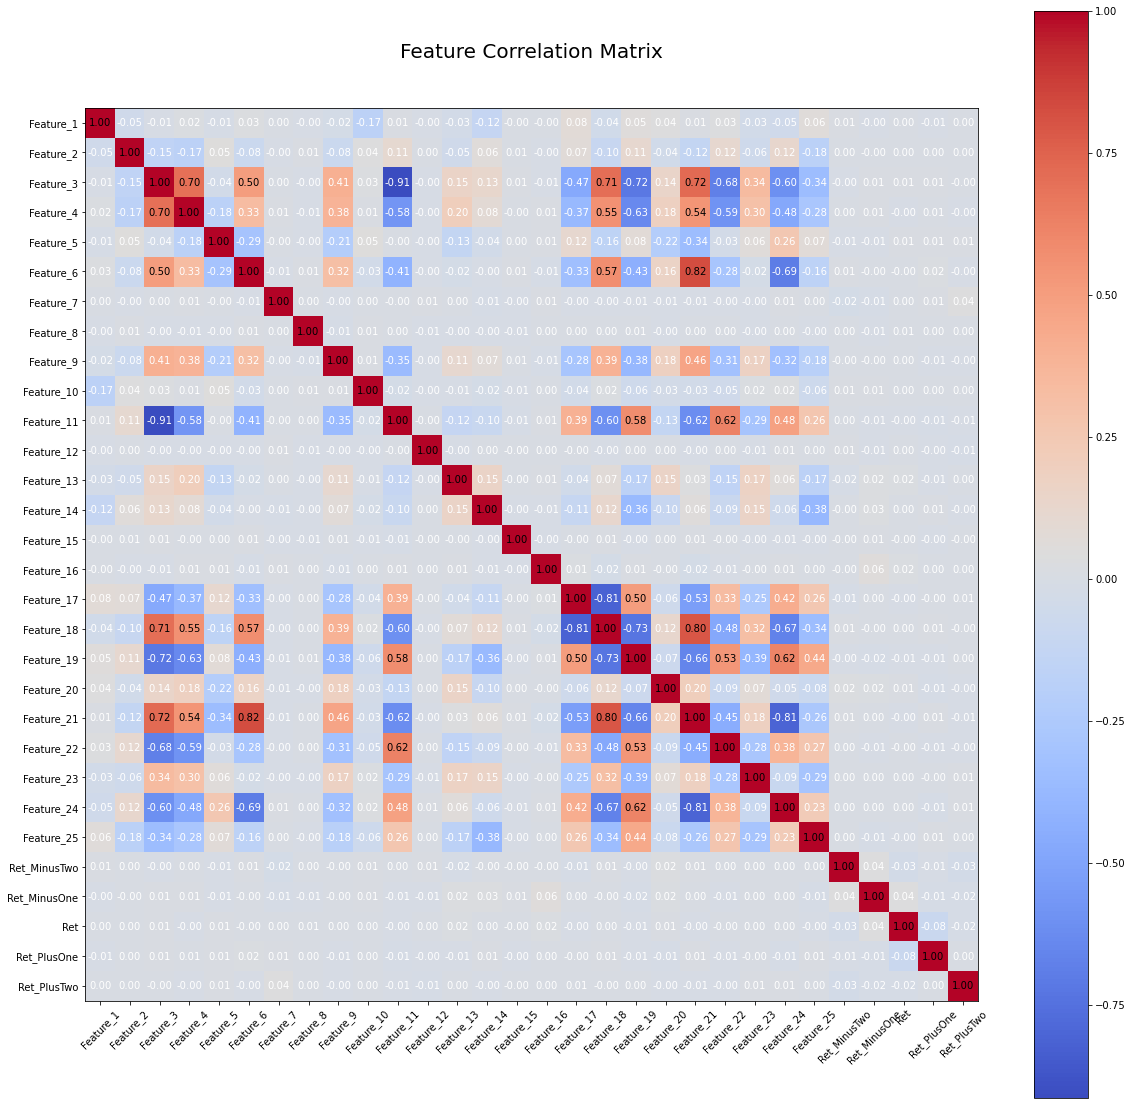

In [9]:
# We show the correlation matrix in the form of a heatmap.
matrix = np.corrcoef(np.hstack([X, y]).T)
columns = list(df.columns[1:28]) + ['Ret', 'Ret_PlusOne', 'Ret_PlusTwo']
hm = heatmap(matrix, row_names = columns, column_names = columns, figsize = (20, 20), cmap=plt.cm.coolwarm)
plt.title('Feature Correlation Matrix', fontsize = 20)
plt.savefig('Correlation Matrix', dpi=300)
plt.show()

## Two independant variables correlation example

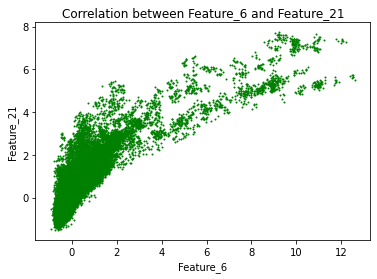

In [10]:
# Scatter plots show the correlation between features pretty well.
plt.scatter(df['Feature_6'], df['Feature_21'], marker = 'o', s = 1, color='green')
plt.title('Correlation between Feature_6 and Feature_21')
plt.xlabel('Feature_6')
plt.ylabel('Feature_21')
plt.savefig('Correlation scatterplot', dpi=300)
plt.show()

## Split into training, validation, and testing data sets for both of the following two days

In [12]:
# Create x train, validation, and test sets.
X_train = X[:30000, :]
X_val = X[30000:35000, :]
X_test = X[35000:, :]

# Create y train, validation, and test sets.
y_train = y[:30000, :]
y_val = y[30000:35000, :]
y_test = y[35000:, :]

X_train_val = X[:35000, :]
y_train_val = y[:35000, :]

In [13]:
# There are two different things here for Ret_PlusOne and Ret_PlusTwo.
# We subdivide each of the following categories.
y1_train = y_train[:, 0]
y2_train = y_train[:, 1]

y1_val = y_val[:, 0]
y2_val = y_val[:, 1]

y1_test = y_test[:, 0]
y2_test = y_test[:, 1]

y1_train_val = y_train_val[:, 0]
y2_train_val = y_train_val[:, 1]

y1 = y[:, 0]
y2 = y[:, 1]

## Use XGBoost for feature selection

In [14]:
import xgboost as xgb

# XGB's internal data structure that is optimized for memory efficiency and speed.
dTrainMatrix = xgb.DMatrix(X_train, label=y1_train)

parameters = { 'verbosity': 0,
          'objective': 'reg:pseudohubererror',
          'eval_metric': 'mae',
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'tree_method': 'gpu_hist',
          'eta': 0.1,
          'max_depth': 5,
          'gamma': 0,
          'min_child_weight': 1 }

# Cross validation.
results = xgb.cv(parameters, dTrainMatrix, nfold=3, num_boost_round=1000, early_stopping_rounds=50)

In [15]:
# Cross validation results.
results

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,0.437725,0.000071,0.437725,0.000217
1,0.385612,0.000071,0.385612,0.000227
2,0.341352,0.000079,0.341352,0.000230
3,0.303265,0.000075,0.303265,0.000249
4,0.270186,0.000075,0.270186,0.000267
...,...,...,...,...
142,0.013551,0.000117,0.015491,0.000118
143,0.013537,0.000117,0.015488,0.000119
144,0.013521,0.000119,0.015484,0.000109
145,0.013512,0.000116,0.015487,0.000109


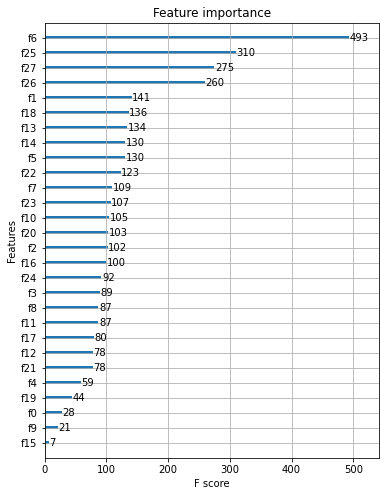

In [17]:
# Plotting feature importances
xgbResults = xgb.train(parameters, dTrainMatrix, num_boost_round=results.shape[0])
fig, ax = plt.subplots(figsize=(6, 8))
xgb.plot_importance(xgbResults, ax=ax)
plt.savefig('Feature Importances', dpi=300)
plt.show()

In [18]:
# These numbers correspond to the determined feature importances in the above graphic.
# Select the top 15 features.
featureIndices = [6, 25, 27, 26, 1, 18, 13, 14, 5, 22, 7, 23, 10, 20, 2]
featureIndices.sort()
print(len(featureIndices))
print(featureIndices)

# Select only the feature importance columns.
X_train = X[:30000, featureIndices]
X_val = X[30000:35000, featureIndices]
X_test = X[35000:, featureIndices]
X_train_val = X[:35000, featureIndices]

15
[1, 2, 5, 6, 7, 10, 13, 14, 18, 20, 22, 23, 25, 26, 27]


## Hyperparameter tuning

In [19]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Hyperparameter search
def hyperSearch(Xtrain, ytrain, Xval, yval, parameter, parameter1, parameter2 = None, estimator = XGBRegressor, score = mean_absolute_error):
    best_score = 10000000.
    best_param = { **parameter }
    para = { **parameter }
    key1 = list(parameter1.keys())[0]
    if parameter2 is not None:
        key2 = list(parameter2.keys())[0]
        for parama in parameter1[key1]:
            for paramb in parameter2[key2]:
                para[key1] = parama
                para[key2] = paramb
                est = estimator(**para)
                est.fit(Xtrain, ytrain)
                y_pred = est.predict(Xval)
                current_score = score(y_pred, yval)
                if (current_score < best_score):
                    best_score = current_score
                    best_param[key1] = parama
                    best_param[key2] = paramb
    else:
        for parama in parameter1[key1]:
            para[key1] = parama
            est = estimator(**para)
            est.fit(Xtrain, ytrain)
            y_pred = est.predict(Xval)
            current_score = score(y_pred, yval)
            print('The current score: ', current_score)
            print('The current parameter: {} = {}'.format(key1, parama))
            if (current_score < best_score):
                best_score = current_score
                best_param[key1] = parama
    return best_score, best_param

In [20]:
# Hyperparameter search
parameters = {'learning_rate': 0.1,
         'verbosity': 0,
         'objective': 'reg:pseudohubererror',
         'tree_method': 'gpu_hist',
         'n_estimators': 100,
         'n_jobs': -1,
         'gamma': 0,
         'subsample': 0.8,
         'colsample_bytree': 0.8,
         'alpha': 0}
param1 = { 'max_depth': [1, 3, 5] }
param2 = { 'min_child_weight': [1, 3, 5] }
score, bst_param = hyperSearch(X_train, y1_train, X_val, y1_val, parameters, param1, param2)
print('The best score is:', score)
print('The best parameter is:', bst_param)

The best score is: 0.015034558942661402
The best parameter is: {'learning_rate': 0.1, 'verbosity': 0, 'objective': 'reg:pseudohubererror', 'tree_method': 'gpu_hist', 'n_estimators': 100, 'n_jobs': -1, 'gamma': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'alpha': 0, 'max_depth': 5, 'min_child_weight': 1}


In [21]:
# Chosen hyperparameters
bestHyper = XGBRegressor( objective = 'reg:pseudohubererror',
                          tree_method = 'gpu_hist',
                          max_depth = 5,
                          min_child_weight = 3,
                          gamma = 0,
                          subsample = 0.9,
                          colsample_bytree = 0.9,
                          alpha = 0,
                          learning_rate = 0.01,
                          n_estimators = 700)

## Report on loss

In [22]:
# Note once again we are predicting two sets of data.

bestHyper.fit(X_train_val, y1_train_val)
y1_test_pred = bestHyper.predict(X_test)

bestHyper.fit(X_train_val, y2_train_val)
y2_test_pred = bestHyper.predict(X_test)

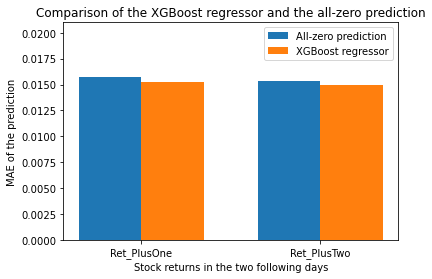

In [23]:
# Report on the training loss.

zeroBenchmark = [np.abs(y1_test).mean(), np.abs(y2_test).mean()]
fitted = [mean_absolute_error(y1_test_pred, y_test[:, 0]), mean_absolute_error(y2_test_pred, y_test[:, 1])]

index = np.arange(2)
bar_width = 0.35
plt.bar(index, zeroBenchmark, bar_width, label = 'All-zero prediction')
plt.bar(index + bar_width, fitted, bar_width, label = 'XGBoost regressor')
plt.xticks(index + bar_width / 2, ['Ret_PlusOne', 'Ret_PlusTwo'])
plt.title('Comparison of the XGBoost regressor and the all-zero prediction')
plt.xlabel('Stock returns in the two following days')
plt.ylabel('MAE of the prediction')
plt.ylim([0, 0.021])
plt.legend()
plt.show()

## Show predictions

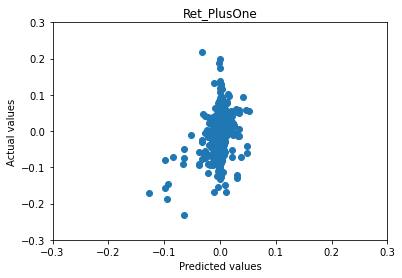

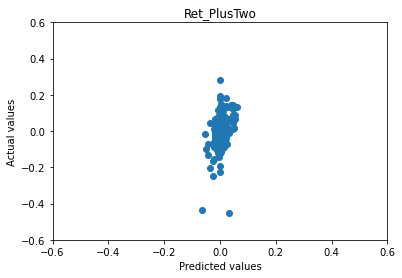

In [37]:
plt.scatter(y1_test_pred, y_test[:, 0])
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Ret_PlusOne')
plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)
plt.savefig('XGBoost Ret_PlusOne Scatterplot', dpi=300)
plt.show()

plt.scatter(y2_test_pred, y_test[:, 1])
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Ret_PlusTwo')
plt.xlim(-0.6, 0.6)
plt.ylim(-0.6, 0.6)
plt.savefig('XGBoost Ret_PlusTwo Scatterplot', dpi=300)
plt.show()

## Other Error Metrics

In [25]:
def getMeanAbsPercentError(yTrueArray, yPredArray):
    epsilonArray = np.full(yTrueArray.shape, 0.01)
    pctChgArray = (yTrueArray - yPredArray) / np.maximum(epsilonArray, np.abs(yTrueArray))
    absPctChgArray = np.abs(pctChgArray)
    return absPctChgArray.sum()

In [26]:
# Report on mean absolute percentage error

zeroArray = np.zeros(shape=(len(y1_test_pred)))

zeroY1Error = getMeanAbsPercentError(zeroArray, y_test[:, 0])
zeroY2Error = getMeanAbsPercentError(zeroArray, y_test[:, 1])

xgBoostY1Error = getMeanAbsPercentError(y1_test_pred, y_test[:, 0])
xgBoostY2Error = getMeanAbsPercentError(y2_test_pred, y_test[:, 1])

print(zeroY1Error,zeroY2Error)
print(xgBoostY1Error, xgBoostY2Error)

7864.483347859903 7648.794983964197
7363.568520540743 7152.608327754508


In [29]:
# Report on r-squared error.
rSquared1 = r2_score(y1_test_pred, y_test[:, 0])
rSquared2 = r2_score(y2_test_pred, y_test[:, 1])

print(rSquared1, rSquared2)

rSquared1 = r2_score(zeroArray, y_test[:, 0])
rSquared2 = r2_score(zeroArray, y_test[:, 1])

print(rSquared1, rSquared2)

-14.77459250890428 -26.432069311274518
0.0 0.0


## Making multiple Kaggle submissions

In [39]:
# Finally, making predictions for our submission.
bestHyper.fit(X[:, featureIndices], y[:, 0])
y1_new_pred = bestHyper.predict(submission_X[:, featureIndices])

bestHyper.fit(X[:, featureIndices], y[:, 1])
y2_new_pred = bestHyper.predict(submission_X[:, featureIndices])

In [42]:
# Finally, making predictions for our submission.
# Let's try it without any feature selection.
bestHyper.fit(X, y[:, 0])
y1_new_pred = bestHyper.predict(submission_X)

bestHyper.fit(X, y[:, 1])
y2_new_pred = bestHyper.predict(submission_X)

In [49]:
# Random forest no feature selection
from sklearn.ensemble import RandomForestRegressor

randomForest = RandomForestRegressor()

randomForest.fit(X, y[:, 0])
y1_new_pred = randomForest.predict(submission_X)

randomForest.fit(X, y[:, 1])
y2_new_pred = randomForest.predict(submission_X)

In [51]:
# Random forest with feature selection
from sklearn.ensemble import RandomForestRegressor
randomForest = RandomForestRegressor()

randomForest.fit(X[:, featureIndices], y[:, 0])
y1_new_pred = randomForest.predict(submission_X[:, featureIndices])

randomForest.fit(X[:, featureIndices], y[:, 1])
y2_new_pred = randomForest.predict(submission_X[:, featureIndices])

In [32]:
# Ignoring 90% of our predictions to reduce noise.
y1_new_pred = 0.1 * y1_new_pred + 0.9 * np.median(y[:, 0])
y2_new_pred = 0.1 * y2_new_pred + 0.9 * np.median(y[:, 1])

In [33]:
# Read the sample submission file.
zip_file = ZipFile('../input/the-winton-stock-market-challenge/sample_submission_2.csv.zip')
sub = pd.read_csv(zip_file.open('sample_submission_2.csv'))
print(sub)

                Id  Predicted
0              1_1          0
1              1_2          0
2              1_3          0
3              1_4          0
4              1_5          0
...            ...        ...
7439995  120000_58          0
7439996  120000_59          0
7439997  120000_60          0
7439998  120000_61          0
7439999  120000_62          0

[7440000 rows x 2 columns]


In [52]:
ts_new_pred = np.zeros((submission_X.shape[0], 60))  # Intraday predictions set to zero

stacked = np.hstack([ts_new_pred, y1_new_pred[:, np.newaxis], np.median(y[:, 1])* np.ones((submission_X.shape[0], 1))])
print(stacked)
sub['Predicted'] = stacked.flatten()
sub.to_csv('submission.csv', index = False)

[[ 0.          0.          0.         ...  0.          0.00580246
  -0.00025822]
 [ 0.          0.          0.         ...  0.          0.00439757
  -0.00025822]
 [ 0.          0.          0.         ...  0.         -0.01586709
  -0.00025822]
 ...
 [ 0.          0.          0.         ...  0.          0.00246983
  -0.00025822]
 [ 0.          0.          0.         ...  0.          0.00211408
  -0.00025822]
 [ 0.          0.          0.         ...  0.         -0.00832802
  -0.00025822]]


In [38]:
# Let's try a new one here where y2 predictions are actually being used.

ts_new_pred = np.zeros((submission_X.shape[0], 60))  # Intraday predictions set to zero

stacked = np.hstack([ts_new_pred, y1_new_pred[:, np.newaxis], y2_new_pred[:, np.newaxis]* np.ones((submission_X.shape[0], 1))])
print(stacked)
sub['Predicted'] = stacked.flatten()
sub.to_csv('submission.csv', index = False)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -8.52360681e-05 -8.52360681e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -9.56877338e-05 -9.56877338e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -6.11381198e-04 -6.11381198e-04]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -8.62195448e-05 -8.62195448e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -3.16475256e-04 -3.16475256e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   1.24611033e-04  1.24611033e-04]]
